#Introduction

- This notebook builds a model for **face recognition**.
- It uses PINS dataset provided by Great Learning.



In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Project_Data/CV/")
images_path = "./PINS.zip"

## 1. Unzip, read and Load data(‘PINS.zip’) into session

In [ ]:
from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

In [ ]:
# To get number of folders in the PINS directory
!ls "PINS/" -1 | wc -l

100


In [ ]:
# Print first 5 folders
!ls -U "PINS/" | head -5

pins_Aaron Paul
pins_alexandra daddario
pins_Alvaro Morte
pins_alycia debnam carey face
pins_Amanda Crew


In [ ]:
# Print first 5 files in the folder "pins_elon musk"
!ls "PINS/pins_elon musk" | head -5

elon musk0.jpg
elon musk10.jpg
elon musk11.jpg
elon musk12.jpg
elon musk13.jpg


## 2. Write function to create metadata of the image

The function uses a pre-trained **Haar cascade classifier** to find faces. The function returns the coordinates of the detected faces as bounding rectangles.

In [ ]:
# Function: GetBoundingBoxInfo()
# Input: Image file name
# Output: Bounding box coordinates of the face in the image

def GetBoundingBoxInfo(file_name):
  img = cv2.imread(cv2.samples.findFile(file_name))
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces_rect =  haar_cascade.detectMultiScale(gray_img, 1.1, 9)
  return faces_rect

## 3. Write a loop to iterate through each and every image and create metadata for all the images

In [ ]:
root_folder = "PINS"
mask_root_folder = "PINS_Mask"

In [ ]:
# Create a folder to store all the mask images
os.mkdir(mask_root_folder)

In [ ]:
import os


persons_cnt = 0

for folder in  os.listdir(root_folder + "/"):
  # images_per_person_cnt = 0
  os.mkdir(mask_root_folder + "/" + folder)         # Create the folder with person name to store all images of the person
  for file in os.listdir(root_folder + "/" + folder + "/"):
    faces_rect = GetBoundingBoxInfo(root_folder + "/" + folder + "/" + file)    # Get bounding box information for each face
    if (len(faces_rect) != 0):
      (x, y, w, h) = faces_rect[0]
      img = cv2.imread(root_folder + "/" + folder + "/" + file)       # Read the face image again
      img_mask = img[y:y+h, x:x+w]                                    # Crop the face from the original image
      cv2.imwrite(mask_root_folder + "/" + folder + "/" + file , img_mask)    # Save the cropped face image in the person's folder



- Let us get the count of cropped faces in each folder of all the persons

In [ ]:
mask_folders_list = os.listdir(mask_root_folder)
folder_count = len(mask_folders_list)
files_in_folders_cnt = []
for folder in  mask_folders_list:
  files_cnt = 0
  for file in os.listdir(mask_root_folder + "/" + folder):
    files_cnt = files_cnt + 1
  files_in_folders_cnt.append(files_cnt)

- Let us find how many total faces, it could find

In [ ]:
total_files = 0
files_in_folders_cnt_df = pd.DataFrame(files_in_folders_cnt).value_counts()
for index, value in zip(files_in_folders_cnt_df.index,files_in_folders_cnt_df.values):
  total_files = total_files + (index[0] * value)
print("Total number of faces identified : ", total_files)

Total number of faces identified :  9247


### Note:
- The data is imbalanced. Minimum number of face images for a person is 28. (Max is 170)
- So let us take first 25 face images of each person.

## 4. Generate Embeddings vectors on each face in the dataset.

In [ ]:
# Build VGG16 model to extract features for each face image i.e. to generate embeddings

from keras import Model       #,Input
from keras .applications import VGG16

# Create VGG16 base model
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3),include_top=True)

print(base_model.summary())
# load the weights
# base_model.load_weights('/content/drive/MyDrive/Colab Notebooks/Project_Data/CV/vgg_face_weights.h5')

# Make the model non-trainable. Because we will use the model only to extract feature.
base_model.trainable = False

# Create a model to extract the features from the second last layers.
# The last layer has softmax function. We want output from the previous layer which is a fully connected/dense layer
model = Model(inputs=base_model.layers[0].input,outputs=base_model.layers[-2].output)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Let us preprocess the data

- To extract the features of each face image, we will use VGG16 model. It requires the input size as 224 * 224.
- So let us convert all face images to size of 224 * 224.
- It is also required to call the preprocess_input() function for all inputs, before using the model for prediction.

In [ ]:
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input

'''for each file in all the mask folders:
  - Load the file with size 224 * 224
  - preprocess it using the keras preprocess module
'''
def PreprocessData():
  X,y = [],[]
  folder_list = os.listdir(mask_root_folder + "/")
  for index,folder in enumerate(folder_list):
    file_count = 1
    for file in os.listdir(mask_root_folder + "/" + folder + "/"):
      img = load_img(mask_root_folder + "/" + folder + "/" + file, target_size=(224,224))
      img=img_to_array(img)
      img=np.expand_dims(img,axis=0)
      img=preprocess_input(img)
      img_encode=model(img)
      X.append(img_encode)
      y.append(index+1)

      file_count = file_count + 1
      if(file_count == 25):
        break;

  return X,y

In [ ]:
X_tensor,y = PreprocessData()

In [ ]:
X = np.array([np.squeeze(item.numpy()) for item in X_tensor])   # Convert the tensor data to a numpy array

In [ ]:
X.shape

(2400, 4096)

In [ ]:
y = np.array(y)
y.shape

(2400,)

#### Standardise the data
- This would be required for appling PCA

In [ ]:
from scipy.stats import zscore
import pandas as pd

XScaled=pd.DataFrame(X).apply(zscore)
XScaled.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.051221,1.902232,-0.083712,-0.147764,-0.421222,-0.450177,-0.154461,-0.221116,-1.026052,-0.350228,...,-0.055597,-0.177999,-0.150141,1.375181,1.031991,-0.676571,-0.04872,-0.053487,-0.080032,-0.599563
1,-0.051221,-0.127829,-0.083712,9.180845,-0.421222,-0.450177,-0.154461,-0.221116,1.646512,-0.350228,...,-0.055597,-0.177999,-0.150141,-0.561411,-0.445587,-0.676571,-0.04872,-0.053487,-0.080032,-0.142341


- Replace NaN values with zero

In [ ]:
XScaled.isnull().sum().sum()

91200

In [ ]:
XScaled = XScaled.replace(np.nan, 0)

In [ ]:
XScaled.isnull().sum().sum()

0

### Let us split the data into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size=0.042, random_state=42, stratify = y )

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2299, 4096), (2299,), (101, 4096), (101,))

In [ ]:
pd.DataFrame(y_train).value_counts()

1     23
76    23
74    23
73    23
72    23
      ..
31    23
30    23
29    23
28    23
52    22
Length: 100, dtype: int64

In [ ]:
(pd.DataFrame(y_train).value_counts() != 23).sum()

1

- The data is balanced. There are 23 face images of each person in the train data. (only the last person has 22 images)

## 6. Use PCA for dimensionality reduction

#### Apply PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1024)
pca.fit(X_train)

PCA(n_components=1024)

In [ ]:
# And the percentage of variation explained by each eigen Vector
# print(pca.explained_variance_ratio_)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[1023]

0.9708188

#### Dimensionality Reduction

- 97% of data variation is explained by 1023 features
- So let us keep 1023 dimensions

In [ ]:
Xpca_train = pca.transform(X_train)

In [ ]:
Xpca_train.shape

(2299, 1024)

In [ ]:
y_train.shape

(2299,)

## 7. Build an SVM classifier in order to map each image to its right person

In [ ]:
from sklearn import svm

clf = svm.SVC(gamma=0.1, C=2)
clf.fit(Xpca_train , y_train)

SVC(C=2, gamma=0.1)

## 9. Use the trained SVM model to predict the face on both test images

- Transform the test data to new PCA dimentions

In [ ]:
Xpca_test = pca.transform(X_test)

In [ ]:
Xpca_test.shape, y_test.shape

((101, 1024), (101,))

In [ ]:
clf.score(Xpca_test , y_test)

0.07920792079207921

In [ ]:
y_pred = clf.predict(Xpca_test)

In [ ]:
correct_predicted_labels = [person_real for person_real, person_pred in zip(y_test, y_pred) if person_real == person_pred]
correct_predicted_labels

[51, 43, 32, 46, 62, 75, 69, 7]

- The model could analyze the faces for above persons (51, 43, 32, 46, 62, 75, 69, 7)
- These are the indexes in persons_folder_list. It can be mapped to the list to get the person name.

## 8. Import and display the the test images

- Let us test individual images

In [ ]:
mask_folders_list[correct_predicted_labels[0] -1]   # Prediction was correct for this person

'pins_Josh Radnor'

- Prediction was correct for "Josh Radnor", label - 51

- Let us get one image of his.

In [ ]:
files_in_folders_cnt = []
folder_name = mask_folders_list[correct_predicted_labels[0] -1]
files_list = os.listdir(mask_root_folder + "/" + folder_name)
file_name = mask_root_folder + "/" + folder_name + "/" + files_list[25]
print(file_name)

PINS_Mask/pins_Josh Radnor/Josh Radnor29.jpg


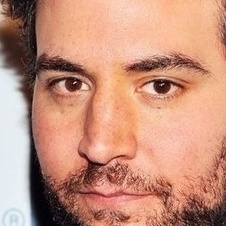

In [ ]:
img = cv2.imread(file_name)
cv2_imshow(img)

- Image needs to be preprocessed, before applig the classification model i.e. SVM

In [ ]:
# A function to extract features of a single face image

def ProcessSingleImage(file_path):
  img = load_img(file_path, target_size=(224,224))
  img=img_to_array(img)
  img=np.expand_dims(img,axis=0)
  img=preprocess_input(img)
  img_encode=model(img)

  return img_encode

In [ ]:
img_extracted_tensor = ProcessSingleImage(file_name)

- Now let us apply classification model to predict the class label

In [ ]:
# Scale the extracted image
# Transform it to new PCA dimentions
# Predict the class

img_extracted = img_extracted_tensor.numpy()
img_extracted = pd.DataFrame(img_extracted).apply(zscore)
img_extracted = img_extracted.replace(np.nan,0)
img_transformed = pca.transform(img_extracted)
pred_class = clf.predict(img_transformed)
pred_class

array([5])

- Let us map the class label '5' to person name.

In [ ]:
# Map the predicted class to the persons folder name
predicted_person = mask_folders_list[pred_class[0]- 1]
predicted_person

'pins_Amanda Crew'